In [1]:
import os

folder = "models"
mode_version = "spec_arr_v1"
mode_version = os.path.join(folder, mode_version)

print(mode_version)

models/spec_arr_v1


In [2]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

In [3]:
import keras
import pandas as pd
import tensorflow as tf

import numpy as np
# from keras.models import Sequential, Model
# from keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import np_utils

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D, Input,AveragePooling2D, BatchNormalization, LeakyReLU, SpatialDropout2D

# from keras.applications import MobileNet
# from keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2, InceptionV3
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

import seaborn as sns
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import KFold

from collections import defaultdict,Counter
from imblearn.over_sampling import SMOTE
from PIL import Image

#from kerastuner import HyperModel

Using TensorFlow backend.


<h2>Data Loading and Preparation</h2>

In [4]:
def getSpeciesCode(x):
    part = x.split('_')
    if part[0] == 'ASETRI':
        return 0
    elif part[0] == 'EPTBOT':
        return 1
    elif part[0] == 'MYOEMA':
        return 2
    elif part[0] == 'PIPKUH':
        return 3
    elif part[0] == 'RHIMUS':
        return 4
    elif part[0] == 'RHYNAS':
        return 5
    elif part[0] == 'ROUAEG':
        return 6
    elif part[0] == 'TAPPER':
        return 7
    else:
        return 'Unknown'
    
def getSpecies(x):
    if x == 0:
        return 'A.tridens'
    elif x == 1:
        return 'E.bottae'
    elif x == 2:
        return 'M.emarginatus'
    elif x == 3:
        return 'P.kuhli'
    elif x == 4:
        return 'R.muscatellum'
    elif x == 5:
        return 'R.nasutus'
    elif x == 6:
        return 'R.aegyptius'
    elif x == 7:
        return 'T.perforatus'
    else:
        return 'Unknown'
    
    
def generate_actual_predicted(Y_pred, X_test, Y_test): 
    predicted = list()
    for i in range(len(Y_pred)):
        predicted.append(np.argmax(Y_pred[i]))
        
    actual = list()
    for i in range(len(Y_test)):
        actual.append(np.argmax(Y_test[i]))
        
    return actual, predicted

In [5]:
X_all = np.load('../../data/spec_array_x.npy', allow_pickle= True)
Y_all =  np.load('../../data/spec_array_y.npy', allow_pickle= True)

print(X_all.shape)
print(Y_all.shape)

X_all = X_all.astype('float32')
X_all /= 255

Y_all = np_utils.to_categorical(Y_all, num_classes=8) 


(3018, 128, 300, 1)
(3018,)


In [6]:
# train /test= 80/20% split
# Data is stratified
X_train, X_test, Y_train, Y_test = train_test_split(X_all, Y_all, test_size=0.2, random_state = 245, stratify=Y_all)


<h2> Train and Save Model</h2>

In [10]:
def build_current_model():
    inp = Input(shape=(128,300,1))
    lay = Convolution2D(filters=56,kernel_size=(7,7),strides=(2,2),padding='same')(inp)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = MaxPooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = Dropout(0.3)(lay)

    lay = Convolution2D(filters=72,kernel_size=(5,5),strides=(2,2),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = Dropout(0.3)(lay)

    lay = Convolution2D(filters=56,kernel_size=(3,3),strides=(1,1),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = Dropout(0.3)(lay)

    lay = Convolution2D(filters=72,kernel_size=(3,3),strides=(1,1),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = Dropout(0.3)(lay)

    lay = Flatten()(lay)

    lay = Dense(48)(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = Dropout(0.15)(lay)

    x_out = Dense(8, name='output', activation='softmax')(lay)
    model = Model(inputs=inp, outputs=x_out)
    model.compile(
        optimizer=Adam(lr=0.003),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [11]:
model = build_current_model()
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 300, 1)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 150, 56)       2800      
_________________________________________________________________
batch_normalization_5 (Batch (None, 64, 150, 56)       224       
_________________________________________________________________
activation_5 (Activation)    (None, 64, 150, 56)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 75, 56)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 32, 75, 56)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 38, 72)        1008

In [12]:
from sklearn.model_selection import StratifiedKFold
n_split=10
n_classes=8

y_all_labelled=[]
for i in range(len(Y_all)):
        y_all_labelled.append(np.argmax(Y_all[i]))
        
my_callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=50,verbose=1, mode='min',restore_best_weights=True)]
       
count = 1

for train_index,test_index in StratifiedKFold(n_split, shuffle=True, random_state=123).split(X_all,y_all_labelled):  
    # use the index to generate training an testing sets
    x_train,x_test=X_all[train_index],X_all[test_index]
    y_train,y_test=Y_all[train_index],Y_all[test_index]
    
    # create and fit the model
    cv_model=build_current_model() # lr,dense,cnn
    history = cv_model.fit(x_train, y_train,
              batch_size=8,
              epochs=100,
              validation_split=0.2,
              verbose=2,
              callbacks=my_callbacks)
    
    
    file_name = mode_version +'_iter_' +str(count)

    #Store History
    hist_df = pd.DataFrame(history.history) 
    hist_json_file = file_name + '.json'
    
    with open(hist_json_file, mode='w') as f:
       hist_df.to_json(f)
    
    model_file = file_name + '.model'
    print(model_file)
    #Save Model
    cv_model.save(model_file) #Save the model
    
    count+=1

  
    

Epoch 1/100
272/272 - 8s - loss: 1.0262 - accuracy: 0.6878 - val_loss: 5.6956 - val_accuracy: 0.0000e+00
Epoch 2/100
272/272 - 2s - loss: 0.8064 - accuracy: 0.7486 - val_loss: 6.8134 - val_accuracy: 0.0000e+00
Epoch 3/100
272/272 - 2s - loss: 0.6949 - accuracy: 0.7661 - val_loss: 14.7751 - val_accuracy: 0.0000e+00
Epoch 4/100
272/272 - 2s - loss: 0.6075 - accuracy: 0.7965 - val_loss: 12.9551 - val_accuracy: 0.0000e+00
Epoch 5/100
272/272 - 2s - loss: 0.5482 - accuracy: 0.8071 - val_loss: 10.6017 - val_accuracy: 0.0000e+00
Epoch 6/100
272/272 - 2s - loss: 0.5234 - accuracy: 0.8140 - val_loss: 16.8075 - val_accuracy: 0.0000e+00
Epoch 7/100
272/272 - 2s - loss: 0.4398 - accuracy: 0.8379 - val_loss: 6.3986 - val_accuracy: 0.0827
Epoch 8/100
272/272 - 2s - loss: 0.4159 - accuracy: 0.8545 - val_loss: 7.7064 - val_accuracy: 0.0496
Epoch 9/100
272/272 - 2s - loss: 0.3623 - accuracy: 0.8665 - val_loss: 8.5871 - val_accuracy: 0.0000e+00
Epoch 10/100
272/272 - 2s - loss: 0.3480 - accuracy: 0.8766

Epoch 24/100
272/272 - 2s - loss: 0.1578 - accuracy: 0.9489 - val_loss: 23.8383 - val_accuracy: 0.0037
Epoch 25/100
272/272 - 2s - loss: 0.1485 - accuracy: 0.9553 - val_loss: 15.6426 - val_accuracy: 0.0331
Epoch 26/100
272/272 - 2s - loss: 0.1291 - accuracy: 0.9572 - val_loss: 14.1988 - val_accuracy: 0.0404
Epoch 27/100
272/272 - 2s - loss: 0.1245 - accuracy: 0.9558 - val_loss: 12.0560 - val_accuracy: 0.1121
Epoch 28/100
272/272 - 2s - loss: 0.1230 - accuracy: 0.9604 - val_loss: 10.7028 - val_accuracy: 0.0625
Epoch 29/100
272/272 - 2s - loss: 0.1155 - accuracy: 0.9572 - val_loss: 14.5809 - val_accuracy: 0.0404
Epoch 30/100
272/272 - 2s - loss: 0.1239 - accuracy: 0.9576 - val_loss: 16.8052 - val_accuracy: 0.0018
Epoch 31/100
272/272 - 2s - loss: 0.1247 - accuracy: 0.9572 - val_loss: 52.1822 - val_accuracy: 0.0000e+00
Epoch 32/100
272/272 - 2s - loss: 0.0985 - accuracy: 0.9669 - val_loss: 10.0177 - val_accuracy: 0.0662
Epoch 33/100
272/272 - 2s - loss: 0.0946 - accuracy: 0.9659 - val_los

Epoch 45/100
272/272 - 2s - loss: 0.0791 - accuracy: 0.9751 - val_loss: 16.8878 - val_accuracy: 0.1066
Epoch 46/100
272/272 - 2s - loss: 0.0654 - accuracy: 0.9779 - val_loss: 19.2736 - val_accuracy: 0.0202
Epoch 47/100
272/272 - 2s - loss: 0.0799 - accuracy: 0.9747 - val_loss: 21.8824 - val_accuracy: 0.0037
Epoch 48/100
272/272 - 2s - loss: 0.0609 - accuracy: 0.9788 - val_loss: 19.0496 - val_accuracy: 0.1048
Epoch 49/100
272/272 - 2s - loss: 0.0602 - accuracy: 0.9761 - val_loss: 23.2688 - val_accuracy: 0.0423
Epoch 50/100
272/272 - 2s - loss: 0.0903 - accuracy: 0.9733 - val_loss: 21.3469 - val_accuracy: 0.0037
Epoch 51/100
272/272 - 2s - loss: 0.0686 - accuracy: 0.9784 - val_loss: 20.3052 - val_accuracy: 0.0423
Epoch 52/100
272/272 - 2s - loss: 0.0563 - accuracy: 0.9779 - val_loss: 15.5558 - val_accuracy: 0.1011
Epoch 53/100
272/272 - 2s - loss: 0.0686 - accuracy: 0.9751 - val_loss: 44.9778 - val_accuracy: 0.0000e+00
Epoch 54/100
Restoring model weights from the end of the best epoch.


Epoch 14/100
272/272 - 2s - loss: 0.2646 - accuracy: 0.9056 - val_loss: 9.7960 - val_accuracy: 0.0993
Epoch 15/100
272/272 - 2s - loss: 0.2298 - accuracy: 0.9231 - val_loss: 10.5658 - val_accuracy: 0.0386
Epoch 16/100
272/272 - 2s - loss: 0.2203 - accuracy: 0.9213 - val_loss: 12.9653 - val_accuracy: 0.0846
Epoch 17/100
272/272 - 2s - loss: 0.1986 - accuracy: 0.9254 - val_loss: 16.1375 - val_accuracy: 0.0110
Epoch 18/100
272/272 - 2s - loss: 0.1766 - accuracy: 0.9337 - val_loss: 18.0460 - val_accuracy: 0.0846
Epoch 19/100
272/272 - 2s - loss: 0.1713 - accuracy: 0.9378 - val_loss: 12.6300 - val_accuracy: 0.0202
Epoch 20/100
272/272 - 2s - loss: 0.2302 - accuracy: 0.9227 - val_loss: 14.5029 - val_accuracy: 0.0074
Epoch 21/100
272/272 - 2s - loss: 0.1713 - accuracy: 0.9415 - val_loss: 15.5748 - val_accuracy: 0.0331
Epoch 22/100
272/272 - 2s - loss: 0.1515 - accuracy: 0.9461 - val_loss: 13.0303 - val_accuracy: 0.0735
Epoch 23/100
272/272 - 2s - loss: 0.1362 - accuracy: 0.9567 - val_loss: 11

Epoch 41/100
272/272 - 2s - loss: 0.0823 - accuracy: 0.9724 - val_loss: 15.1632 - val_accuracy: 0.0404
Epoch 42/100
272/272 - 2s - loss: 0.0743 - accuracy: 0.9756 - val_loss: 37.8867 - val_accuracy: 0.0000e+00
Epoch 43/100
272/272 - 2s - loss: 0.0992 - accuracy: 0.9696 - val_loss: 22.0228 - val_accuracy: 0.0018
Epoch 44/100
272/272 - 2s - loss: 0.0986 - accuracy: 0.9659 - val_loss: 15.5300 - val_accuracy: 0.1176
Epoch 45/100
272/272 - 2s - loss: 0.0760 - accuracy: 0.9756 - val_loss: 16.2693 - val_accuracy: 0.0478
Epoch 46/100
272/272 - 2s - loss: 0.0584 - accuracy: 0.9811 - val_loss: 16.5560 - val_accuracy: 0.1103
Epoch 47/100
272/272 - 2s - loss: 0.0520 - accuracy: 0.9816 - val_loss: 18.4039 - val_accuracy: 0.0919
Epoch 48/100
272/272 - 2s - loss: 0.0636 - accuracy: 0.9770 - val_loss: 15.3964 - val_accuracy: 0.0551
Epoch 49/100
272/272 - 2s - loss: 0.1125 - accuracy: 0.9678 - val_loss: 16.2887 - val_accuracy: 0.1158
Epoch 50/100
272/272 - 2s - loss: 0.0537 - accuracy: 0.9830 - val_los

Epoch 15/100
272/272 - 2s - loss: 0.2364 - accuracy: 0.9222 - val_loss: 15.4178 - val_accuracy: 0.0055
Epoch 16/100
272/272 - 2s - loss: 0.2124 - accuracy: 0.9286 - val_loss: 8.9240 - val_accuracy: 0.0607
Epoch 17/100
272/272 - 2s - loss: 0.2024 - accuracy: 0.9342 - val_loss: 9.9000 - val_accuracy: 0.0625
Epoch 18/100
272/272 - 2s - loss: 0.1772 - accuracy: 0.9351 - val_loss: 9.7293 - val_accuracy: 0.1121
Epoch 19/100
272/272 - 2s - loss: 0.1736 - accuracy: 0.9411 - val_loss: 10.0755 - val_accuracy: 0.0607
Epoch 20/100
272/272 - 2s - loss: 0.1825 - accuracy: 0.9397 - val_loss: 14.6237 - val_accuracy: 0.0386
Epoch 21/100
272/272 - 2s - loss: 0.1555 - accuracy: 0.9494 - val_loss: 17.9597 - val_accuracy: 0.0018
Epoch 22/100
272/272 - 2s - loss: 0.1563 - accuracy: 0.9507 - val_loss: 15.4322 - val_accuracy: 0.0239
Epoch 23/100
272/272 - 2s - loss: 0.1406 - accuracy: 0.9521 - val_loss: 15.3263 - val_accuracy: 0.0257
Epoch 24/100
272/272 - 2s - loss: 0.1389 - accuracy: 0.9544 - val_loss: 12.8

Epoch 40/100
272/272 - 2s - loss: 0.1072 - accuracy: 0.9618 - val_loss: 11.7856 - val_accuracy: 0.1066
Epoch 41/100
272/272 - 2s - loss: 0.0862 - accuracy: 0.9733 - val_loss: 14.2510 - val_accuracy: 0.0864
Epoch 42/100
272/272 - 2s - loss: 0.0696 - accuracy: 0.9765 - val_loss: 18.8447 - val_accuracy: 0.0349
Epoch 43/100
272/272 - 2s - loss: 0.0911 - accuracy: 0.9682 - val_loss: 13.0248 - val_accuracy: 0.1103
Epoch 44/100
272/272 - 2s - loss: 0.1002 - accuracy: 0.9650 - val_loss: 25.8584 - val_accuracy: 0.0257
Epoch 45/100
272/272 - 2s - loss: 0.0835 - accuracy: 0.9733 - val_loss: 15.6226 - val_accuracy: 0.1121
Epoch 46/100
272/272 - 2s - loss: 0.0857 - accuracy: 0.9673 - val_loss: 17.8731 - val_accuracy: 0.0901
Epoch 47/100
272/272 - 2s - loss: 0.0768 - accuracy: 0.9775 - val_loss: 19.4712 - val_accuracy: 0.0735
Epoch 48/100
272/272 - 2s - loss: 0.0950 - accuracy: 0.9728 - val_loss: 16.3904 - val_accuracy: 0.0588
Epoch 49/100
272/272 - 2s - loss: 0.0707 - accuracy: 0.9751 - val_loss: 1

# Load and Evaluate

In [13]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve
from sklearn.metrics import confusion_matrix

n_split=10
n_classes=8


In [14]:
all_base_precision = list()
all_base_recall = list()
all_macro_precision = list()
all_macro_recall = list()
all_f1 = list()
all_macro_f1 = list()

all_tpr = list()
all_fpr = list()
all_precision = list()
all_recall = list()
all_cm=list()
all_accuracy = list()

all_df = list()

y_all_labelled=[]
for i in range(len(Y_all)):
        y_all_labelled.append(np.argmax(Y_all[i]))
             
count = 1


for train_index,test_index in StratifiedKFold(n_split, shuffle=True, random_state=123).split(X_all,y_all_labelled):  
    # use the index to generate training an testing sets
    x_train,x_test=X_all[train_index],X_all[test_index]
    y_train,y_test=Y_all[train_index],Y_all[test_index]
    
    file_name = mode_version +'_iter_' +str(count)

    #Load History 
    hist_json_file = file_name + '.json'
    history_info = pd.read_json(hist_json_file)
    all_df.append(history_info)
    
   
    # Load Model
    model_file = file_name + '.model'
    cv_model = tf.keras.models.load_model(model_file) 
    
    count+=1

    #generate predictions
    y_pred = cv_model.predict(x_test)
    actual, predicted = generate_actual_predicted(y_pred, x_test, y_test)
    
    #calc metrics
    curr_base_prec, curr_base_rec, curr_f1, _ = precision_recall_fscore_support(actual, predicted)
    curr_macro_prec = precision_score(actual, predicted,average='macro')
    curr_macro_rec = recall_score(actual, predicted,average='macro')
    curr_macro_f1 = f1_score(actual, predicted,average='macro')
    
    actual_labeled = list()
    predict_labeled = list()
    for x,y in zip(actual,predicted):
        actual_labeled.append(getSpecies(x))
        predict_labeled.append(getSpecies(y))
        
    labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']
    curr_cm=confusion_matrix(actual_labeled,predict_labeled,labels=labels)
    
    curr_fpr = [0] * n_classes
    curr_tpr = [0] * n_classes
    for i in range(n_classes):
        curr_fpr[i], curr_tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])
        
    curr_prec = [0] * n_classes
    curr_rec = [0] * n_classes
    for i in range(n_classes):
        curr_prec[i], curr_rec[i], _ = precision_recall_curve(y_test[:,i], y_pred[:,i])

        
    curr_accuracy = accuracy_score(actual, predicted)
    
    #add to lists
    all_base_precision.append(curr_base_prec)
    all_base_recall.append(curr_base_rec)
    all_macro_precision.append(curr_macro_prec)
    all_macro_recall.append(curr_macro_rec)
    
    all_f1.append(curr_f1)
    all_macro_f1.append(curr_macro_f1)
    
    all_accuracy.append(curr_accuracy)

    
    all_fpr.append(curr_fpr)
    all_tpr.append(curr_tpr)
    all_precision.append(curr_prec)
    all_recall.append(curr_rec)
    all_cm.append(curr_cm)

    
    
    

/home/team9/anaconda3/envs/gpu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/team9/anaconda3/envs/gpu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


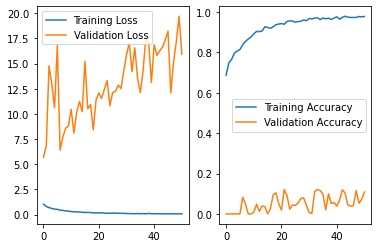

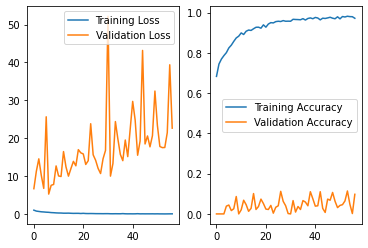

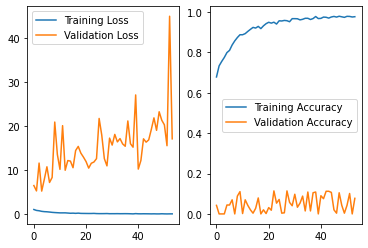

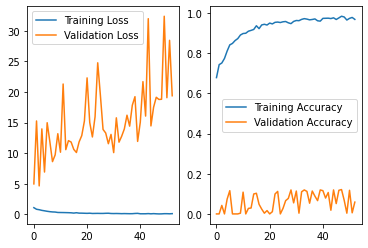

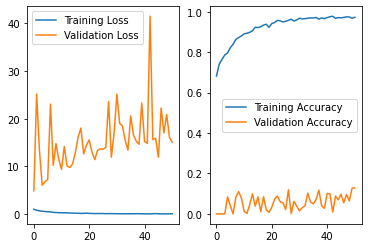

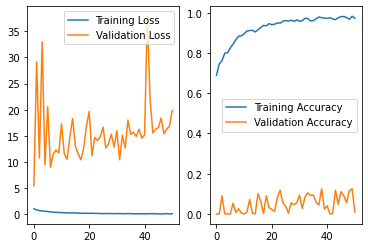

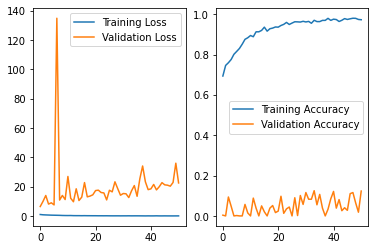

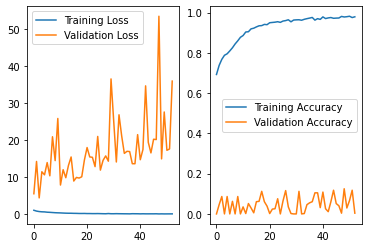

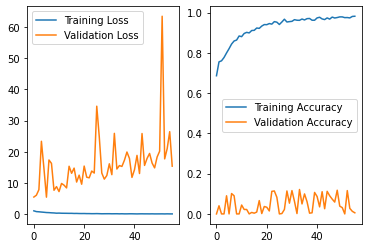

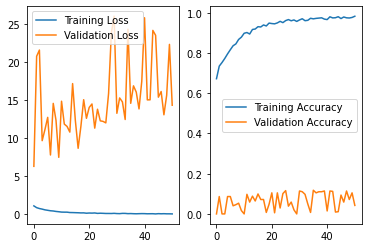

In [15]:
for df in all_df:
    _, axs = plt.subplots(ncols=2)

    sns.lineplot(data=df['loss'],ax=axs[0], label='Training Loss', legend='brief')
    sns.lineplot(data=df['val_loss'],ax=axs[0], label='Validation Loss', legend='brief')

    sns.lineplot(data=df['accuracy'],ax=axs[1], label='Training Accuracy', legend='brief')
    sns.lineplot(data=df['val_accuracy'],ax=axs[1], label='Validation Accuracy', legend='brief')

In [16]:
print('precision mean by class', np.array(all_base_precision).mean(axis=0))
print('precision sdev by class', np.array(all_base_precision).std(axis=0))

print('macro precision mean', np.array(all_macro_precision).mean())
print('macro precision sdev', np.array(all_macro_precision).std())


print('recall mean', np.array(all_base_recall).mean(axis=0))
print('recall sdev', np.array(all_base_recall).std(axis=0))

print('macro recall mean', np.array(all_macro_recall).mean())
print('macro recall sdev', np.array(all_macro_recall).std())

print('f1 mean', np.array(all_f1).mean(axis=0))
print('f1 sdev', np.array(all_f1).std(axis=0))

print('macro f1 mean', np.array(all_macro_f1).mean())
print('macro f1 sdev', np.array(all_macro_f1).std())

print('accuracy mean', np.array(all_accuracy).mean())
print('accuracy sdev', np.array(all_accuracy).std())



precision mean by class [0.14       0.02       0.         0.3570387  0.59864206 0.14015873
 0.         0.        ]
precision sdev by class [0.31048349 0.06       0.         0.34426955 0.05384827 0.20248121
 0.         0.        ]
macro precision mean 0.15697993646715339
macro precision sdev 0.0631045223865156
recall mean [0.2        0.00833333 0.         0.22103448 0.93801313 0.15185185
 0.         0.        ]
recall sdev [0.4        0.025      0.         0.21343132 0.08866523 0.27886208
 0.         0.        ]
macro recall mean 0.18990409978869754
macro recall sdev 0.05368628932463014
f1 mean [0.15714286 0.01176471 0.         0.21079012 0.72611679 0.11167929
 0.         0.        ]
f1 sdev [0.32857143 0.03529412 0.         0.18145544 0.03318579 0.1933255
 0.         0.        ]
macro f1 mean 0.15218672144803294
macro f1 sdev 0.0496942961912682
accuracy mean 0.5549822886185123
accuracy sdev 0.042298239756807424


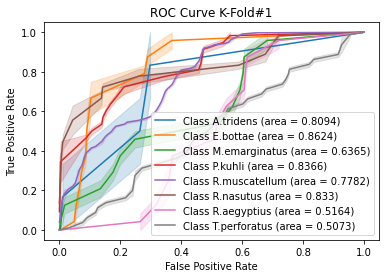

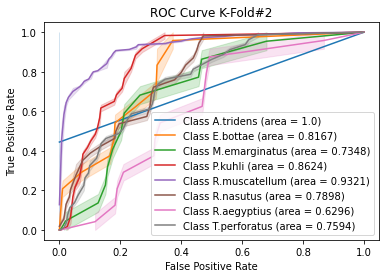

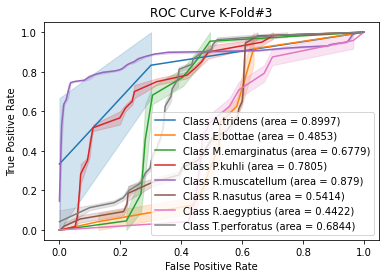

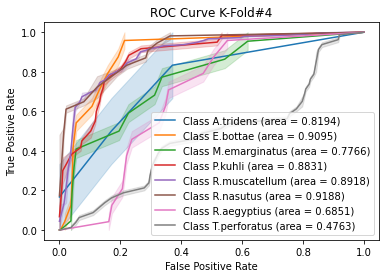

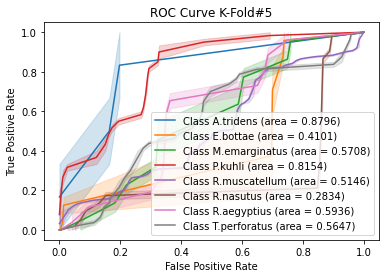

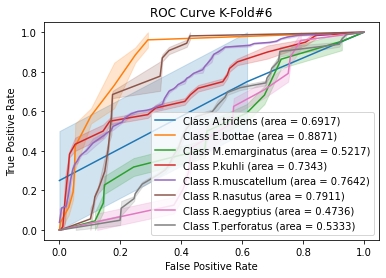

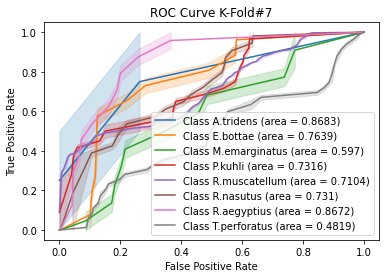

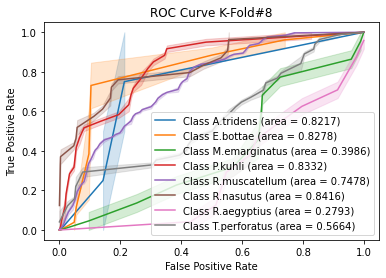

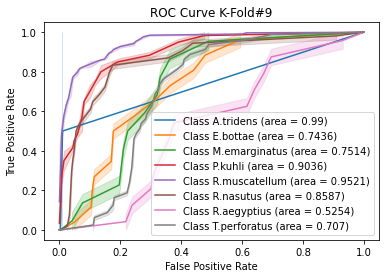

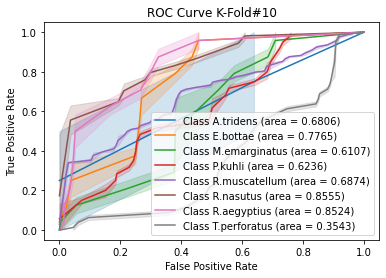

In [17]:
# Plot all K-Fold ROC curves

for i in range(n_split):
    _, axs = plt.subplots(ncols=1)
    axs.set(xlabel='False Positive Rate',ylabel='True Positive Rate', title='ROC Curve K-Fold#'+str(i+1))
    for j in range(n_classes):
        auc_val = auc(all_fpr[i][j], all_tpr[i][j])
        auc_val = np.around(auc_val,4)
        sns.lineplot(x=all_fpr[i][j],y=all_tpr[i][j],ax=axs, label='Class '+ getSpecies(j) +' (area = ' + str(auc_val) + ')', legend='brief')
        

In [18]:
aucs = list()

for i in range(n_classes):
    aucs.append(list())


# Plot all K-Fold ROC curves

for i in range(n_split):
    for j in range(n_classes):
        auc_val = auc(all_fpr[i][j], all_tpr[i][j])
        aucs[j].append(auc_val)
        
for i in range(n_classes):
    print("Sp: ", getSpecies(i))
    print("AUC Mean ", np.array(aucs[i]).mean())
    print("Std ", np.array(aucs[i]).std())

Sp:  A.tridens
AUC Mean  0.8460261984392419
Std  0.10137416319218082
Sp:  E.bottae
AUC Mean  0.748286554752967
Std  0.15933448654312343
Sp:  M.emarginatus
AUC Mean  0.6276044863120532
Std  0.10942085935850582
Sp:  P.kuhli
AUC Mean  0.8004301247670267
Std  0.0804227723151921
Sp:  R.muscatellum
AUC Mean  0.7857637410429947
Std  0.12642453636497555
Sp:  R.nasutus
AUC Mean  0.7444425916596656
Std  0.18199755370410436
Sp:  R.aegyptius
AUC Mean  0.5864688826068732
Std  0.17254112221216453
Sp:  T.perforatus
AUC Mean  0.5635010719908462
Std  0.1164647582240152


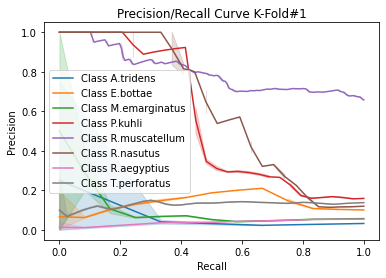

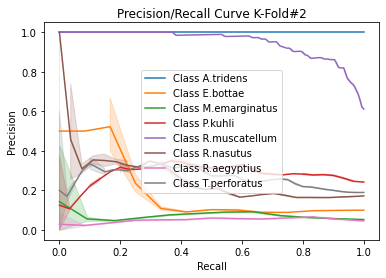

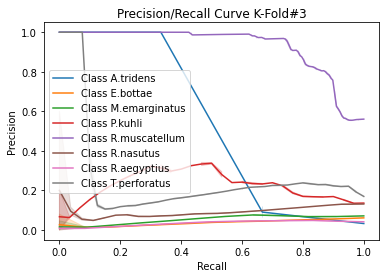

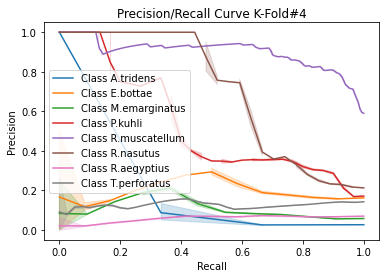

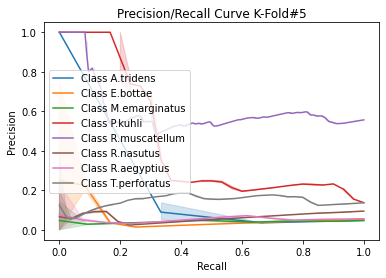

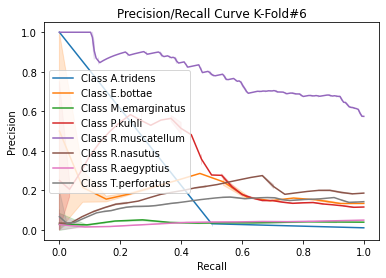

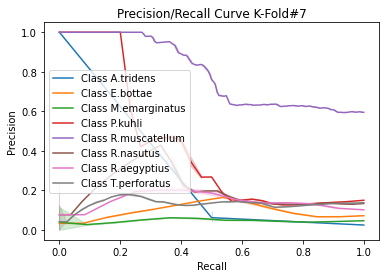

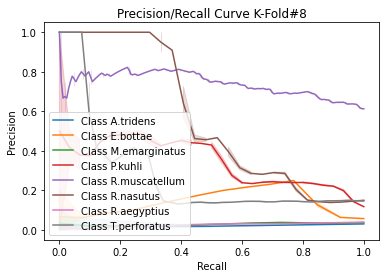

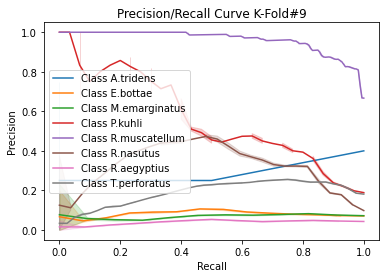

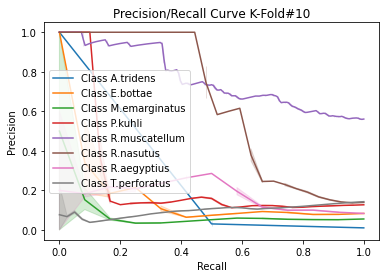

In [19]:
#Plot all K-Fold Precision/Recall curves
for i in range(n_split):
    _, axs = plt.subplots(ncols=1)
    axs.set(xlabel='Recall',ylabel='Precision', title='Precision/Recall Curve K-Fold#'+str(i+1))
    for j in range(n_classes):
        sns.lineplot(x=all_recall[i][j],y=all_precision[i][j],ax=axs, label='Class '+ getSpecies(j), legend='brief')

Confusion Matrix K-Fold #1

[[  0   0   0   0   3   0   0   0]
 [  0   0   0   1  11   0   0   0]
 [  0   0   0   0  12   0   0   0]
 [  0   0   0   9  20   0   0   0]
 [  0   0   0   0 167   0   0   0]
 [  0   0   0   0  27   0   0   0]
 [  0   0   0   0  12   0   0   0]
 [  0   0   0   0  40   0   0   0]]


Confusion Matrix K-Fold #2

[[  3   0   0   0   0   0   0   0]
 [  0   0   0   0  12   0   0   0]
 [  0   0   0   0  11   0   0   0]
 [  0   0   0   0  29   1   0   0]
 [  0   0   0   0 167   0   0   0]
 [  0   0   0   1  24   2   0   0]
 [  0   0   0   2  10   0   0   0]
 [  0   0   0   1  37   2   0   0]]


Confusion Matrix K-Fold #3

[[  0   0   0   0   3   0   0   0]
 [  0   0   0   0  12   0   0   0]
 [  0   0   0   0  11   0   0   0]
 [  0   0   0   0  29   1   0   0]
 [  0   4   0   0 161   2   0   0]
 [  0   0   0   0  26   1   0   0]
 [  0   2   0   0   9   1   0   0]
 [  0   0   0   1  39   0   0   0]]


Confusion Matrix K-Fold #4

[[  0   0   0   0   3   0   0   0]
 [  

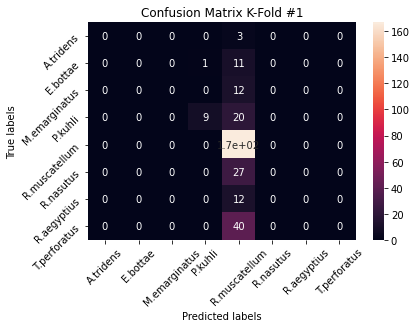

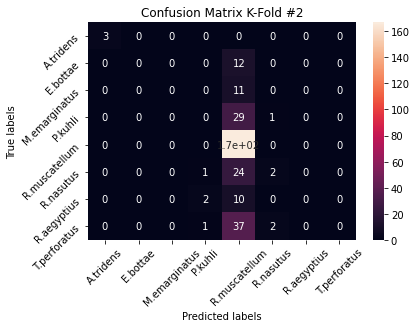

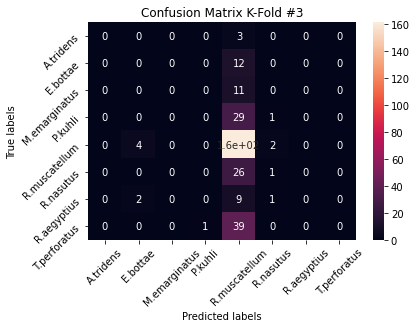

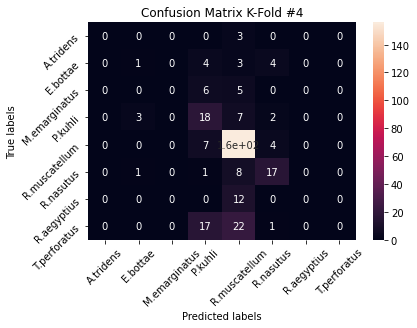

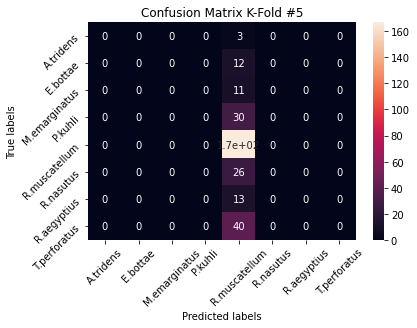

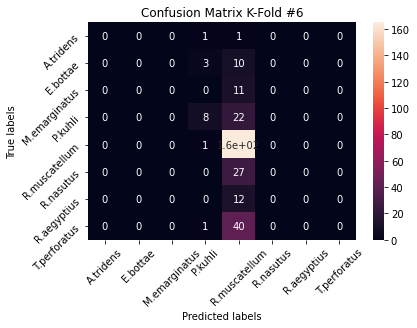

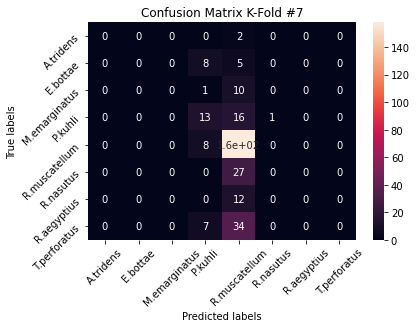

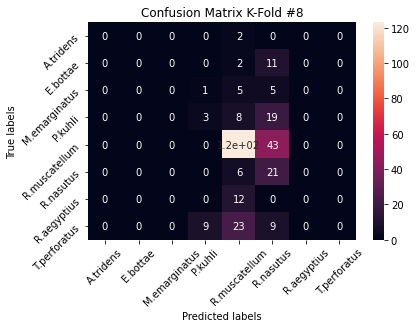

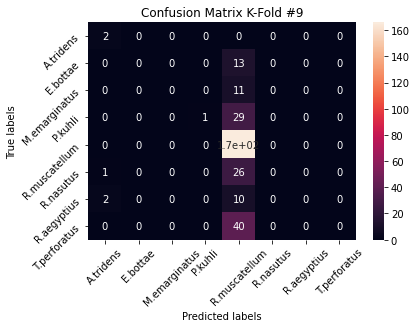

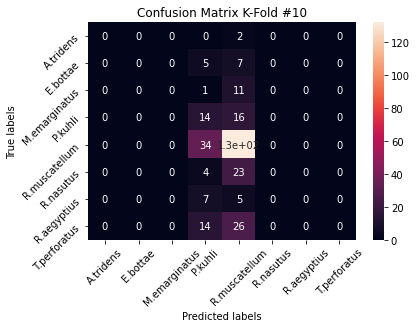

In [20]:
## Plot all K-Fold confusion matrices
import numpy as np
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt

# Create 1X 5 sub plots
# gs = gridspec.GridSpec(1,n_split)
figs=[]
for i in range(n_split):
    figs.append(plt.figure())
    
for i in range(n_split):
    print('Confusion Matrix K-Fold #'+ str(i+1)+"\n")
    print(all_cm[i])
    print("\n")
    
    ax=figs[i].add_subplot()
    sns.heatmap(all_cm[i], annot=True, ax = ax); #annot=True to annotate cells

    
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix K-Fold #'+ str(i+1)); 
    ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);

sum of all confuion matrices
 [[   5    0    0    1   19    0    0    0]
 [   0    1    0   21   87   15    0    0]
 [   0    0    0    9   98    5    0    0]
 [   0    3    0   66  206   24    0    0]
 [   0    4    0   50 1562   49    0    0]
 [   1    1    0    6  220   41    0    0]
 [   2    2    0    9  107    1    0    0]
 [   0    0    0   50  341   12    0    0]]

average of all confuion matrices
 [[  0   0   0   0   1   0   0   0]
 [  0   0   0   2   8   1   0   0]
 [  0   0   0   0   9   0   0   0]
 [  0   0   0   6  20   2   0   0]
 [  0   0   0   5 156   4   0   0]
 [  0   0   0   0  22   4   0   0]
 [  0   0   0   0  10   0   0   0]
 [  0   0   0   5  34   1   0   0]]


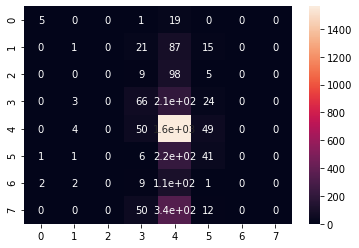

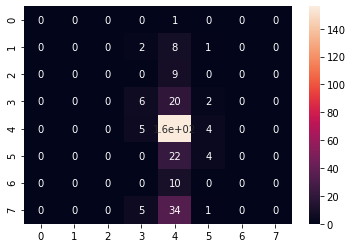

In [21]:
## plot macro cm

sum_all_cm=np.zeros((n_classes,n_classes)).astype('int64')
for i in range(n_split):
    sum_all_cm+=all_cm[i]
    
    
#plot 
figs=[]
for i in range(2):
    figs.append(plt.figure())
       
print("sum of all confuion matrices\n",sum_all_cm)
ax=figs[0].add_subplot()
sns.heatmap(sum_all_cm, annot=True, ax = ax);

avg_all_cm=np.divide(sum_all_cm,n_split).astype('int64')
print("\naverage of all confuion matrices\n",avg_all_cm)
ax=figs[1].add_subplot()
sns.heatmap(avg_all_cm, annot=True, ax = ax);

[[0.2  0.   0.   0.04 0.76 0.   0.   0.  ]
 [0.   0.01 0.   0.17 0.7  0.12 0.   0.  ]
 [0.   0.   0.   0.08 0.88 0.04 0.   0.  ]
 [0.   0.01 0.   0.22 0.69 0.08 0.   0.  ]
 [0.   0.   0.   0.03 0.94 0.03 0.   0.  ]
 [0.   0.   0.   0.02 0.82 0.15 0.   0.  ]
 [0.02 0.02 0.   0.07 0.88 0.01 0.   0.  ]
 [0.   0.   0.   0.12 0.85 0.03 0.   0.  ]]


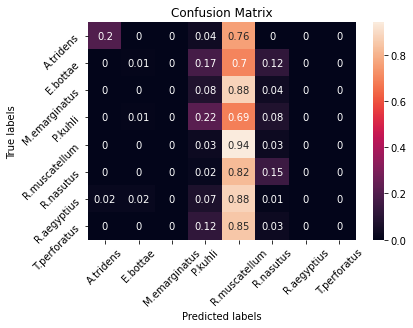

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


cm= sum_all_cm/ sum_all_cm.astype(np.float).sum(axis=1,keepdims = True)
cm = (np.around(cm,2))
print(cm)


labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']


ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);